In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import Dataset ,DataLoader

In [2]:
class AbsDataset(Dataset):
    
    def __init__(self, transform=None):
        xy = np.loadtxt('4Combinations.csv',delimiter=",", dtype=np.float32, skiprows=1)
        self.x = xy[:,:6]
        self.y = xy[:,7:]
        self.n_samples = xy.shape[0]
        
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples

class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)
    
dataset = AbsDataset(transform=ToTensor())

In [3]:
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [4]:
composed = torchvision.transforms.Compose([ToTensor()])
dataset_new = AbsDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [5]:
# hyperparameters
input_size = 6
hidden_size = 500
hidden_size2 = 400
num_classes = 776
num_epochs = 376
batch_size = 30
learning_rate = 0.01
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)

57 15


In [6]:
train_size = int(0.7 * len(dataset_new))
test_size = len(dataset_new) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_new, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([30, 6]) torch.Size([30, 776])


In [7]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes)

Root mean squared error
Training: 0.2149667951051618
Test 0.2335637


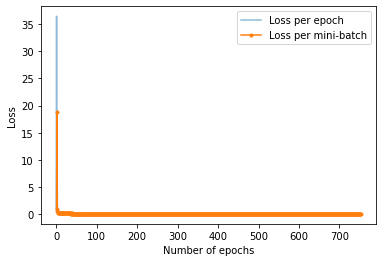

In [8]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("Root mean squared error")
print("Training:", np.sqrt(loss_per_batch[-1]))
print("Test", np.sqrt(criterion(labels.float(), outputs).detach().cpu().numpy()))

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Absolute Error
Training: 0.157325878739357
Test 0.17397586


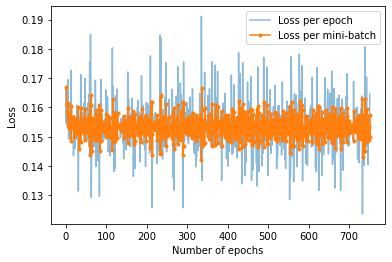

In [9]:
# Loss and Optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("Mean Absolute Error")
print("Training:",(loss_per_batch[-1]))
print("Test", (criterion(labels.float(), outputs).detach().cpu().numpy()))

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Absolute Percentage Error
Training: 44.103572845458984
Test 145.33687


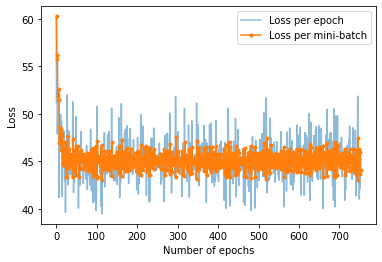

In [10]:
def MAPE(outputs, labels):
    outputs, labels = outputs, labels
    return torch.mean(torch.abs((labels - outputs) / labels)) * 100

# Loss and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = MAPE(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("Mean Absolute Percentage Error")
print("Training:", (loss_per_batch[-1]))
print("Test", (MAPE(labels.float(), outputs).detach().cpu().numpy()))

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

mean squared error
Training: 0.04482380114495754
Test 0.05471223


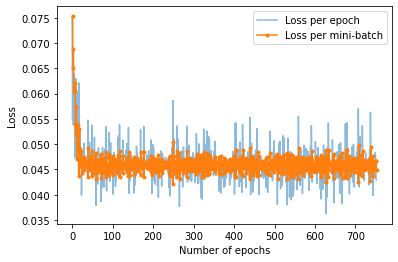

In [11]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("mean squared error")
print("Training:", (loss_per_batch[-1]))
print("Test", (criterion(labels.float(), outputs).detach().cpu().numpy()))

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

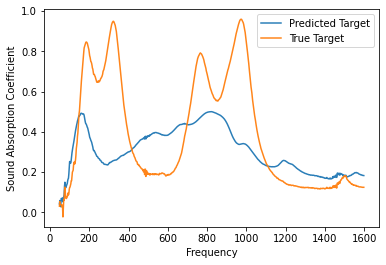

In [19]:
# Comparison between True and Predicted Target Values 
freq_range = range(48,1600,2)
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
torch.no_grad()
outputs = outputs.detach().numpy()

plt.plot(freq_range, outputs[1], "-", alpha=14,label="Predicted Target")
plt.plot(freq_range, labels[1], "-", alpha=14, label="True Target")
plt.xlabel("Frequency")
plt.ylabel("Sound Absorption Coefficient")
plt.legend()
plt.show()

In [13]:
# Optimal Configuration Examination (Below 300Hz)
# Original Samples
dataiter = iter(test_loader)
inputs_real, labels_real = dataiter.next()
inputs_real = inputs_real
labels_real = labels_real
indexes_real = (labels_real[:,:125] > 0.8).nonzero(as_tuple=True)
indexes_real = indexes_real[0]  # Indexes where there's any coefficient value greater than 0.8 in the range of 300Hz

# Tested Samples
dataiter = iter(test_loader)
inputs_test, labels_test = dataiter.next()
inputs_test = inputs_test
labels_test = labels_test
outputs_test = model(inputs_test)
indexes_test = (outputs_test[:,:125] > 0.8).nonzero(as_tuple=True)
indexes_test = indexes_test[0]
outputs_test = outputs_test.detach().numpy()

# Find the actual samples that meet the optimal configuration
indexes_real = list(indexes_real)
optimal_coef_real = []
for i in indexes_real:
    if i not in optimal_coef_real:
        optimal_coef_real.append(i)

# Find the predicted samples that meet the optimal configuration
indexes_test = list(indexes_test)
optimal_coef_test = []
for i in indexes_test:
    if i not in optimal_coef_test:
        optimal_coef_test.append(i)

print("Number of the actual samples that meet the config below 300Hz is", len(optimal_coef_real))
print("Number of the predicted samples that meet the config below 300Hz is", len(optimal_coef_test))

# How many predicted samples match the actual samples
Match_samples = [element for element in optimal_coef_real if element in optimal_coef_test]
print("The prediction accuracy of the algorithm is", len(Match_samples)/len(optimal_coef_real))

# How many incorrect samples the algorithm predicted
Unmatch_samples = [element for element in optimal_coef_test if element not in optimal_coef_real]
print("The number of the incorrectly predicted samples is", len(Unmatch_samples))

Number of the actual samples that meet the config below 300Hz is 2
Number of the predicted samples that meet the config below 300Hz is 0
The prediction accuracy of the algorithm is 0.0
The number of the incorrectly predicted samples is 0


In [14]:
optimal_coef_real

[tensor(1), tensor(8)]

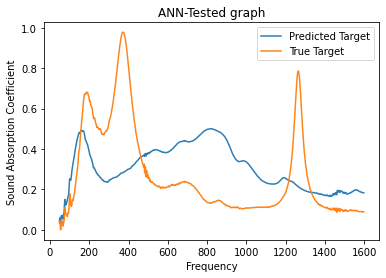

In [15]:
plt.plot(freq_range, outputs_test[7], "-", alpha=14, label="Predicted Target")
plt.plot(freq_range, labels_real[7], "-", alpha=14, label="True Target")
plt.xlabel("Frequency")
plt.ylabel("Sound Absorption Coefficient")
plt.legend(loc=1)
plt.title("ANN-Tested graph")
plt.show()

In [16]:
Unmatch_samples

[]

In [17]:
import seaborn as sns
import tensorflow as tf
labels.tolist()
labels = labels.numpy()

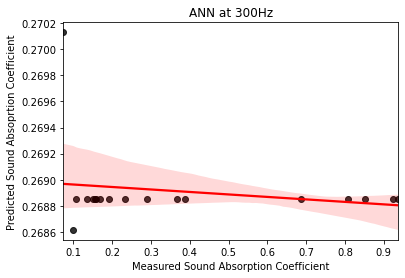

In [18]:
sns.regplot(x=labels[:,150], y= outputs[:,150], scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN at 300Hz")
plt.show()